Loading modules...
This task needs numpy, pandas and matplotlib


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading data... \
Gender and Nationality should be coded

In [31]:
class dataLoader:
    def __init__(self, data) -> None:
        self.data = data
    
    def code_country(self):
        country_dict = {'France':0, 'Spain':1, 'Germany':2}
        for i in range(len(self.data['country'])):
            self.data['country'][i] = country_dict[self.data['country'][i]]
            
    def code_gender(self):
        gender_dict = {'Female':0, 'Male':1}
        for i in range(len(self.data['gender'])):
            self.data['gender'][i] = gender_dict[self.data['gender'][i]]
    
    def regularize(self, label='norm'):
        features = self.data.columns[:-1]
        if label == 'none':
            self.data = self.data
        elif label == 'norm':
            for feature in features:
                mu = self.data[feature].mean()
                sigma = self.data[feature].var()
                self.data[feature] = (self.data[feature] - mu) / sigma
        elif label == 'unif':
            for feature in features:
                self.data[feature] = (self.data[feature] - self.data[feature].min()) / (self.data[feature].max() - self.data[feature].min())
        else:
            raise(NotImplementedError)
    
    def preprocess(self, country_coded=True, gender_coded=True, label='norm'):
        self.data.drop(columns=['customer_id'], axis=1, inplace=True)
        
        if country_coded == False:
            self.data.drop(columns=['country'], axis=1, inplace=True)
        else:
            self.code_country()
            
        if gender_coded == False:
            self.data.drop(columns=['gender'], axis=1, inplace=True)
        else:
            self.code_gender()
        
        self.regularize(label)
    

In [32]:
class logisticTrain:
    def __init__(self, data, train_set=7000, valid_set=8000, test_set=10000, lr=0.001, Lambda=0.001, batch=100, epochs=100, T=0.001) -> None:
        self.data = np.array(data, dtype=np.float32)
        
        self.x = np.column_stack((np.ones((len(self.data[:,0]),1)), self.data[:,:-1]))
        self.train_x = self.x[:train_set,:]
        self.valid_x = self.x[train_set:valid_set,:]
        self.test_x = self.x[valid_set:test_set,:]
        
        self.t = np.array(self.data[:,-1])
        self.train_t = self.t[:train_set]
        self.valid_t = self.t[train_set:valid_set]
        self.test_t = self.t[valid_set:test_set]
        
        self.w = np.zeros((len(self.x[0,:]), 1))
        self.lr =  lr
        self.Lambda = Lambda
        self.batch = batch
        self.epochs = epochs
        self.T = T
        self.loss = []
        self.precision = []
        self.recall = []
        self.accuracy = []
        # self.LR = []
        
        
    def train(self):
        its = len(self.train_t) // self.batch
        for epoch in range(self.epochs):
            lr = self.lr * np.exp(-self.T*epoch)
            # self.LR.append(lr)
            # lr = self.lr
            # self.LR.append(lr)
            for it in range(its):
                x = self.train_x[it*self.batch:(it+1)*self.batch, :] 
                t = self.train_t[it*self.batch:(it+1)*self.batch].reshape(-1,1)
                y = 1. / (1. + np.exp(-np.dot(x, self.w)))
                loss = -np.sum(t*np.log(y) + (1-t)*np.log(1-y)) + 0.5*self.Lambda*np.dot(self.w.T, self.w)
                # loss = -np.sum(t*np.log(y) + (1-t)*np.log(1-y))/self.batch + 0.5*self.Lambda*np.dot(self.w.T, self.w)
                # loss = -np.sum(t*np.log(y) + (1-t)*np.log(1-y))/self.batch
                self.loss.append(loss.item())
                dw = np.dot(x.T, y-t) + self.Lambda*self.w
                # dw = np.dot(x.T, y-t)/self.batch + self.Lambda*self.w
                # dw = np.dot(x.T, y-t)/self.batch 
                self.w = self.w - lr*dw
        
            if len(self.valid_t) > 0:
                y = (np.sign(np.dot(self.valid_x, self.w)) + 1) / 2 
                self.test(y, self.valid_t)
            
            if len(self.test_t) > 0:
                y = (np.sign(np.dot(self.test_x, self.w)) + 1) / 2 
                self.test(y, self.test_t)
    
    
    def regTrain(self):
        its = len(self.train_t) // self.batch
        for epoch in range(self.epochs):
            lr = self.lr * np.exp(-self.T*epoch)
            for it in range(its):
                x = self.train_x[it*self.batch:(it+1)*self.batch, :] 
                t = self.train_t[it*self.batch:(it+1)*self.batch].reshape(-1,1)
                y = np.dot(x, self.w)
                loss = 0.5*(np.sum(np.square(t-y)) + self.Lambda*np.dot(self.w.T, self.w))
                self.loss.append(loss.item())
                dw = np.dot(x.T, y-t) + self.Lambda*self.w
                self.w = self.w - lr*dw
            
            if len(self.valid_t) > 0:
                y = (np.sign(np.dot(self.valid_x, self.w) - 0.5) + 1) / 2 
                self.test(y, self.valid_t)
            
            if len(self.test_t) > 0:
                y = (np.sign(np.dot(self.test_x, self.w) - 0.5) + 1) / 2 
                self.test(y, self.test_t)
    

    def test(self, y, t):
        NTP = 0
        NFP = 0
        NFN = 0
        NTN = 0
        eps = 1e-6
        for i in range(len(t)):
            if t[i] == 0 and y[i] == 0:
                NTN = NTN + 1
            if t[i] == 1 and y[i] == 0:
                NFN = NFN + 1
            if t[i] == 1 and y[i] == 1:
                NTP = NTP + 1
            if t[i] == 0 and y[i] == 1:
                NFP = NFP + 1
        self.precision.append(NTP / (NTP + NFP + eps))
        self.recall.append(NTP / (NTP + NFN + eps))
        self.accuracy.append((NTP + NTN) / len(t))
       
        
    def draw(self, title):
        plt.figure('loss')
        plt.plot(self.loss)
        plt.show()
        
        plt.figure(title)
        plt.plot(self.accuracy)
        plt.plot(self.precision)
        plt.plot(self.recall)
        plt.legend(['accuracy', 'precision', 'recall'])
        plt.show()

In [33]:
data = pd.read_csv('Bank Customer Churn Prediction.csv')
data_loader = dataLoader(data)
data_loader.data

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Test if gender and nationality can influence factors

In [34]:
country_list = []
for i in  data_loader.data['country']:
    if i not in country_list:
        country_list.append(i)
country_list

['France', 'Spain', 'Germany']

In [35]:
country_dict = {'France':{'balance':[], 'cnt':0, 'mean':0, 'var':0}, 
                'Spain':{'balance':[], 'cnt':0, 'mean':0, 'var':0}, 
                'Germany':{'balance':[], 'cnt':0, 'mean':0, 'var':0}}

for i in range(len(data_loader.data)):
    country_dict[data_loader.data['country'][i]]['balance'].append(data_loader.data['balance'][i])
    country_dict[data_loader.data['country'][i]]['cnt'] += 1
for i in country_list:
    country_dict[i]['mean'] = np.mean(country_dict[i]['balance'])
    country_dict[i]['var'] = np.var(country_dict[i]['balance'])
    del(country_dict[i]['balance'])
country_dict

{'France': {'cnt': 5014, 'mean': 62092.63651575588, 'var': 4112293900.949328},
 'Spain': {'cnt': 2477, 'mean': 61818.14776342349, 'var': 4124540744.872411},
 'Germany': {'cnt': 2509, 'mean': 119730.1161339179, 'var': 729897788.9038652}}

In [36]:
gender_list = []
for i in  data_loader.data['gender']:
    if i not in gender_list:
        gender_list.append(i)
gender_list

['Female', 'Male']

In [37]:
gender_dict = {'Male':{'estimated_salary':[], 'cnt':0, 'mean':0, 'var':0}, 
               'Female':{'estimated_salary':[], 'cnt':0, 'mean':0, 'var':0}}

for i in range(len(data_loader.data)):
    gender_dict[data_loader.data['gender'][i]]['estimated_salary'].append(data_loader.data['estimated_salary'][i])
    gender_dict[data_loader.data['gender'][i]]['cnt'] += 1
for i in gender_list:
    gender_dict[i]['mean'] = np.mean(gender_dict[i]['estimated_salary'])
    gender_dict[i]['var'] = np.var(gender_dict[i]['estimated_salary'])
    del(gender_dict[i]['estimated_salary'])
gender_dict

{'Male': {'cnt': 5457, 'mean': 99664.5769305479, 'var': 3320392831.70809},
 'Female': {'cnt': 4543, 'mean': 100601.54138234646, 'var': 3290711045.756901}}

In [38]:
data_loader.preprocess(country_coded=True, gender_coded=True, label='norm')
data = data_loader.data
data

/var/folders/tk/zqv59clj1fg1yb9mw3b1w_100000gn/T/ipykernel_12819/3437161120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['country'][i] = country_dict[self.data['country'][i]]
/var/folders/tk/zqv59clj1fg1yb9mw3b1w_100000gn/T/ipykernel_12819/3437161120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['gender'][i] = gender_dict[self.data['gender'][i]]


,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,-0.003375,-1.086832,-2.200969,0.027985,-0.360181,-1.964483e-05,-1.567147,1.417293,1.941176,3.805462e-07,1
1,-0.004552,0.363244,-2.200969,0.018894,-0.479732,1.880593e-06,-1.567147,-3.395246,1.941176,3.764929e-06,0
2,-0.015899,-1.086832,-2.200969,0.027985,0.357121,2.136285e-05,4.344385,1.417293,-2.062075,4.184886e-06,1
3,0.005189,-1.086832,-2.200969,0.000711,-0.479732,-1.964483e-05,1.388619,-3.395246,-2.062075,-1.893784e-06,0
4,0.021352,0.363244,-2.200969,0.037077,-0.360181,1.259169e-05,-1.567147,1.417293,1.941176,-6.351146e-06,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.012896,-1.086832,1.832325,0.000711,-0.001530,-1.964483e-05,1.388619,1.417293,-2.062075,-1.154845e-06,0
9996,-0.014401,-1.086832,1.832325,-0.035655,0.596222,-4.909874e-06,-1.567147,1.417293,1.941176,4.866368e-07,0
9997,0.006259,-1.086832,-2.200969,-0.026563,0.237571,-1.964483e-05,-1.567147,-3.395246,1.941176,-1.753754e-05,1
9998,0.013003,1.813321,1.832325,0.027985,-0.240631,-3.622968e-07,1.388619,1.417293,-2.062075,-2.177419e-06,1


In [39]:
# data = np.array(data_loader.data, dtype=np.float32)
# np.save('data.npy', data)

In [40]:
# data = np.load('data.npy')

In [41]:
trainer = logisticTrain(data, 
                        train_set=8000, 
                        valid_set=8000, 
                        test_set=10000, 
                        lr=0.00001,
                        Lambda=0.001, 
                        batch=8000, 
                        epochs=100,
                        T=0.0001)

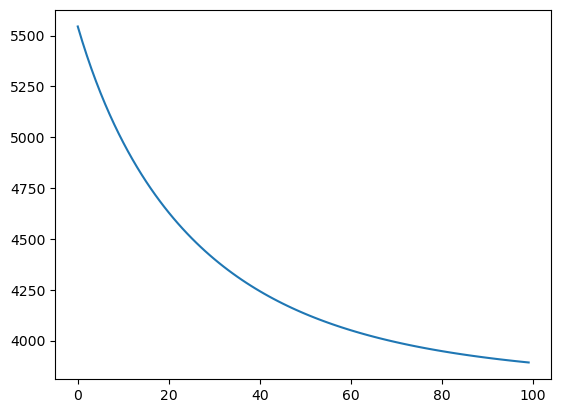

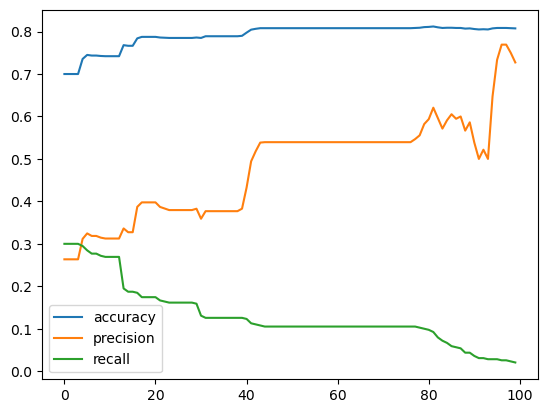

In [42]:
trainer.train()
trainer.draw('test')

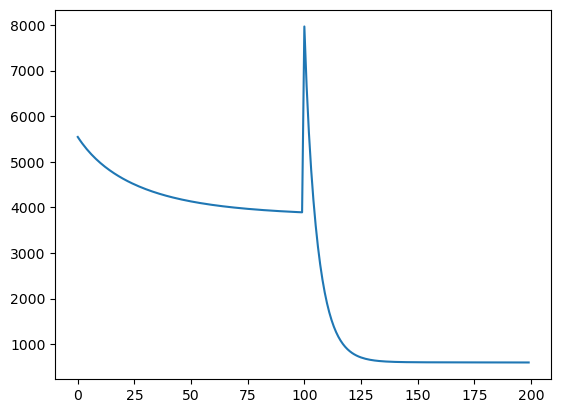

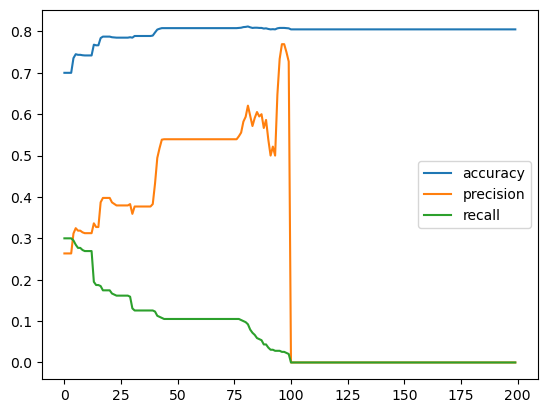

In [43]:
trainer.regTrain()
trainer.draw('test') 